# Programming Assignment 1: Fully-Connected Networks (100 points)
(adapted from the work done by Erik Learned-Miller, which was originally developed by Fei-Fei Li, Andrej Karpathy, and Justin Johnson)

## Overview
<font size='4'>In this assignment, we will implement fully-connected networks using a modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass. After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures. In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization.

## Submission format
* <font size='4'>`<your_nu_username>.ipynb` with your implementations and output.
    
## Note:
* <font size='4'>Do not install any additional packages inside the conda environment. The TAs will use the same environment as defined in the config file we provide you, so anything that’s not in there by default will probably cause your code to break during grading. Failure to follow any of these instructions will lead to point deductions.
* <font size='4'>We have some inline questions embedded in the Jupyter notebook files. Do not miss them.

### Setup

In [1]:
# download helper code
!wget https://jianghz.me/teaching/neural_networks/fc_utils.zip
!unzip fc_utils.zip

--2025-02-05 14:47:07--  https://jianghz.me/teaching/neural_networks/fc_utils.zip
Resolving jianghz.me (jianghz.me)... 145.223.106.135, 2a02:4780:b:1097:0:3662:bf27:2
Connecting to jianghz.me (jianghz.me)|145.223.106.135|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40934 (40K) [application/zip]
Saving to: ‘fc_utils.zip’

fc_utils.zip        100%[===================>]  39.97K  --.-KB/s    in 0.06s   

2025-02-05 14:47:08 (701 KB/s) - ‘fc_utils.zip’ saved [40934/40934]

Archive:  fc_utils.zip
   creating: utils/
  inflating: utils/solver.py         
  inflating: __MACOSX/utils/._solver.py  
  inflating: utils/gradient_check.py  
  inflating: __MACOSX/utils/._gradient_check.py  
 extracting: utils/__init__.py       
  inflating: __MACOSX/utils/.___init__.py  
   creating: utils/__pycache__/
  inflating: utils/data_utils.py     
  inflating: __MACOSX/utils/._data_utils.py  
  inflating: utils/vis_utils.py      
  inflating: __MACOSX/utils/._vis_utils.py  
  inf

In [2]:
from __future__ import print_function
import random
import numpy as np
import time
from utils.data_utils import load_CIFAR10, get_CIFAR10_data
from utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from utils.solver import Solver
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [3]:
# let's download the data
# 1 -- Linux
# 2 -- MacOS
# 3 -- Command Prompt on Windows
# 4 -- manually downloading the data
choice = 2


if choice == 1:
    # should work well on Linux and in Powershell on Windows
    !wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
elif choice == 2 or choice ==3:
    # if wget is not available for you, try curl
    # should work well on MacOS
    !curl http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz --output cifar-10-python.tar.gz
else:
    print('Please manually download the data from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and put it under the datasets folder.')
!tar -xzvf cifar-10-python.tar.gz

if choice==3:
    !del cifar-10-python.tar.gz
else:
    !rm cifar-10-python.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  61.4M      0  0:00:02  0:00:02 --:--:-- 61.4M
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [4]:
# Load the raw CIFAR-10 data.
cifar10_dir = './cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


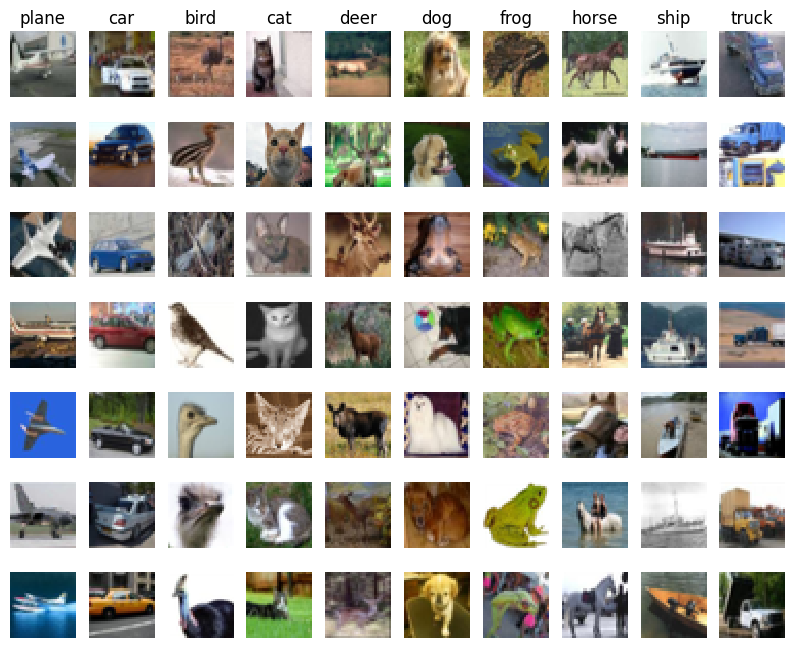

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# Split the data into train, val, and test sets.
# Check the get_CIFAR10_data function for more details
data = get_CIFAR10_data(cifar10_dir)
for k, v in list(data.items()):
    print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Programming assignments start here

### Part 1: Linear and non-linear layers (40 points)

<font size='4' color='red'>**Task 1.1: Affine layer: foward pass (no for loops are allowed) (7 points).**

In [7]:
def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    ###########################################################################
    # TODO: Implement the affine forward pass. Store the result in out. You   #
    # will need to reshape the input into rows.                               #
    ###########################################################################

    N = x.shape[0]
    x_row = x.reshape(N, -1)
    out = x_row.dot(w) + b

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = (x, w, b)
    return out, cache

In [8]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


<font size='4' color='red'>**Task 1.2: Affine layer: backward pass (no for loops are allowed) (7 points).**
    
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [9]:
def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None
    ###########################################################################
    # TODO: Implement the affine backward pass.                               #
    ###########################################################################

    N = x.shape[0]
    x_reshaped = x.reshape(N, -1)
    dx = dout.dot(w.T)
    dx = dx.reshape(x.shape)
    dw = x_reshaped.T.dot(dout)
    db = dout.sum(axis=0)

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dw, db

In [10]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


<font size='4' color='red'>**Task 1.3: ReLU activation: forward pass (no for loops are allowed) (4 points).**
    
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [11]:
def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    ###########################################################################
    # TODO: Implement the ReLU forward pass.                                  #
    ###########################################################################

    out = np.maximum(0, x)

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = x
    return out, cache

In [12]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


<font size='4' color='red'>**Task 1.4: ReLU activation: backward pass (no for loops are allowed) (4 points).**
    
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [13]:
def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    ###########################################################################
    # TODO: Implement the ReLU backward pass.                                 #
    ###########################################################################

    x = cache
    dx = dout * (x > 0)

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx

In [14]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


<font size='4' color='red'>**Task 1.5: "Sandwich" layers (no for loops are allowed) (8 points where 4 for the forward and 4 for the backward).**
    
<font size='4'>There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity.

<font size='4'>Implement the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass.
    
<font size='4'>You need to re-use the functions you have implemented earlier. You need to decide how to use the cached results given by `affine_forward` and `relu_forward`.

In [15]:
def affine_relu_forward(x, w, b):
    """
    Convenience layer that perorms an affine transform followed by a ReLU

    Inputs:
    - x: Input to the affine layer
    - w, b: Weights for the affine layer

    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """

    out, cache = None, None
    ###########################################################################
    # TODO: Implement the Affine-ReLU forward pass.                           #
    ###########################################################################

    a, fc_cache = affine_forward(x, w, b)
    out, relu_cache = relu_forward(a)
    cache = (fc_cache, relu_cache)

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return out, cache


def affine_relu_backward(dout, cache):
    """
    Backward pass for the affine-relu convenience layer

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: cached results from the affine_relu_forward pass

    Returns:
    - dx: Gradient with respect to x
    - dw: Gradient with respect to w
    - db: Gradient with respect to b

    """

    dx, dw, db = None, None, None
    ###########################################################################
    # TODO: Implement the Affine-ReLU backward pass.                          #
    ###########################################################################

    fc_cache, relu_cache = cache
    da = relu_backward(dout, relu_cache)
    dx, dw, db = affine_backward(da, fc_cache)

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return dx, dw, db

In [16]:
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  2.299579177309368e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


<font size='4' color='red'>**Task 1.6: Softmax loss layer (no for loops are allowed) (10 points).**

In [17]:
def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """

    loss, dx = None, None

    ###########################################################################
    # TODO: Implement the softmax_loss function,                              #
    # including the forward and backward passes.                              #
    ###########################################################################

    shifted_logits = x - np.max(x, axis=1, keepdims=True)
    Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    log_probs = shifted_logits - np.log(Z)
    probs = np.exp(log_probs)
    N = x.shape[0]
    loss = -np.sum(log_probs[np.arange(N), y]) / N
    dx = probs
    dx[np.arange(N), y] -= 1
    dx /= N

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return loss, dx

In [18]:
# Let's check your implementation
np.random.seed(5330)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))


Testing softmax_loss:
loss:  2.302800487936905
dx error:  9.169036380620271e-09


### Part 2: Fully-Connected Neural Networks (60 points)

<font size='4' color='red'>**Task 2.1: Two-layer network (no for loops are allowed in your implementation) (15 points)**
    
<font size='4'>Complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [19]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network with ReLU nonlinearity and
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.

    The architecure should be affine - relu - affine - softmax.

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """

    def __init__(self, input_dim=3*32*32, hidden_dim=100, num_classes=10,
                 weight_scale=1e-3, reg=0.0):
        """
        Initialize a new network.

        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dim: An integer giving the size of the hidden layer
        - num_classes: An integer giving the number of classes to classify
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - reg: Scalar giving L2 regularization strength.
        """
        self.params = {}
        self.reg = reg

        ############################################################################
        # TODO: Initialize the weights and biases of the two-layer net. Weights    #
        # should be initialized from a Gaussian centered at 0.0 with               #
        # standard deviation equal to weight_scale, and biases should be           #
        # initialized to zero. All weights and biases should be stored in the      #
        # dictionary self.params, with first layer weights                         #
        # and biases using the keys 'W1' and 'b1' and second layer                 #
        # weights and biases using the keys 'W2' and 'b2'.                         #
        ############################################################################

        self.params['W1'] = weight_scale * np.random.randn(input_dim, hidden_dim)
        self.params['b1'] = np.zeros(hidden_dim)
        self.params['W2'] = weight_scale * np.random.randn(hidden_dim, num_classes)
        self.params['b2'] = np.zeros(num_classes)

        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################


    def loss(self, X, y=None):
        """
        Compute loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the two-layer net, computing the    #
        # class scores for X and storing them in the scores variable.              #
        ############################################################################

        W1, b1, W2, b2 = self.params['W1'], self.params['b1'], self.params['W2'], self.params['b2']
        N, D = X.shape
        hidden_layer, cache_hidden = affine_relu_forward(X, W1, b1)
        scores, cache_scores = affine_forward(hidden_layer, W2, b2)

        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores

        loss, grads = 0, {}
        ############################################################################
        # TODO: Implement the backward pass for the two-layer net. Store the loss  #
        # in the loss variable and gradients in the grads dictionary. Compute data #
        # loss using softmax, and make sure that grads[k] holds the gradients for  #
        # self.params[k]. Don't forget to add L2 regularization!                   #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient. It's sufficient to   #
        # compute the L2 regularization for the weights (W1, W2) only.             #
        ############################################################################

        data_loss, dscores = softmax_loss(scores, y)
        reg_loss = 0.5 * self.reg * (np.sum(W1**2) + np.sum(W2**2))
        loss = data_loss + reg_loss

        grads = {}
        dhidden, grads['W2'], grads['b2'] = affine_backward(dscores, cache_scores)
        grads['W2'] += self.reg * W2
        _, grads['W1'], grads['b1'] = affine_relu_backward(dhidden, cache_hidden)
        grads['W1'] += self.reg * W1

        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads

In [20]:
# Let's check your implementation
np.random.seed(5330)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.12e-10
b1 relative error: 9.83e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 2.85e-08
b1 relative error: 1.56e-08
b2 relative error: 7.76e-10


<font size='4' color='red'>**Task 2.2: Solver (3 points).**
    
<font size='4'>Following a more modular design, we have split the logic for training models into a separate class.

<font size='4'>Open the file `utils/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that <font color='red'>achieves at least `50%` accuracy on the validation set.

In [21]:
from utils.solver import Solver

model = TwoLayerNet()
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

data = {
    'X_train': X_train_flat,
    'y_train': y_train,
    'X_val': X_test_flat,
    'y_val': y_test
}

model = TwoLayerNet(
    input_dim=3*32*32,
    hidden_dim=150,
    num_classes=10,
    weight_scale=1e-3,
    reg=0.1
)

solver = Solver(model, data,
                update_rule='sgd',
                optim_config={
                    'learning_rate': 1e-3,
                },
                lr_decay=0.95,
                num_epochs=40,
                batch_size=256,
                print_every=100)

solver.train()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 7800) loss: 2.328800
(Epoch 0 / 40) train acc: 0.112000; val_acc: 0.124100
(Iteration 101 / 7800) loss: 2.173224
(Epoch 1 / 40) train acc: 0.228000; val_acc: 0.228000
(Iteration 201 / 7800) loss: 2.182598
(Iteration 301 / 7800) loss: 2.230540
(Epoch 2 / 40) train acc: 0.278000; val_acc: 0.282400
(Iteration 401 / 7800) loss: 2.111186
(Iteration 501 / 7800) loss: 1.959332
(Epoch 3 / 40) train acc: 0.267000; val_acc: 0.266300
(Iteration 601 / 7800) loss: 2.005667
(Iteration 701 / 7800) loss: 2.133558
(Epoch 4 / 40) train acc: 0.331000; val_acc: 0.333000
(Iteration 801 / 7800) loss: 1.952209
(Iteration 901 / 7800) loss: 1.795805
(Epoch 5 / 40) train acc: 0.307000; val_acc: 0.299100
(Iteration 1001 / 7800) loss: 1.844941
(Iteration 1101 / 7800) loss: 1.929158
(Epoch 6 / 40) train acc: 0.392000; val_acc: 0.355200
(Iteration 1201 / 7800) loss: 1.749221
(Iteration 1301 / 7800) loss: 1.810843
(Epoch 7 / 40) train acc: 0.346000; val_acc: 0.373600
(Iteration 1401 / 7800) loss: 1.85

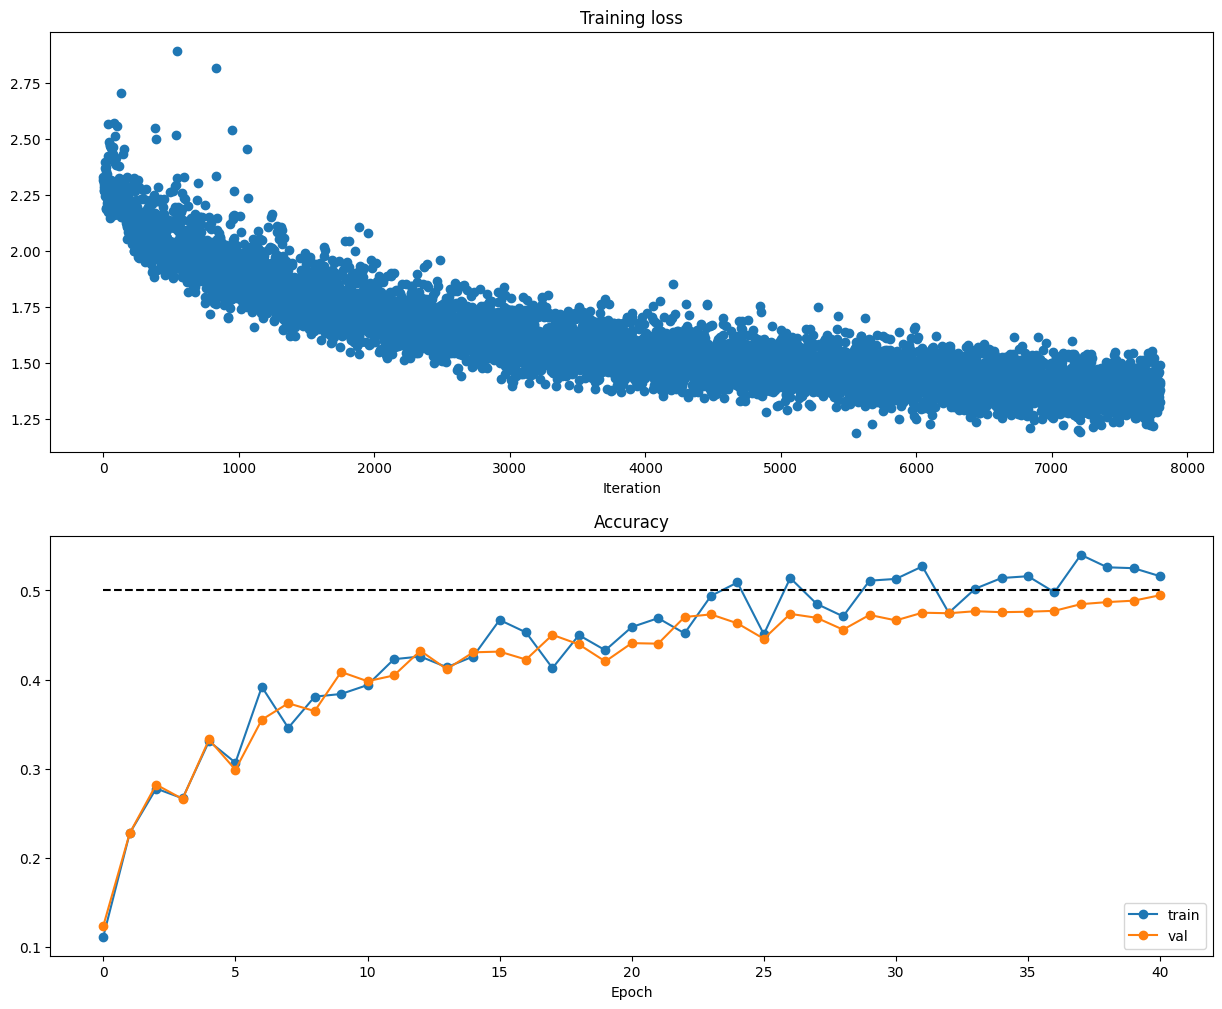

In [22]:
# Run this cell to visualize training loss and train / val accuracy
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

<font size='4' color='red'>**Task 2.3: Multilayer network (18 points).**
    
<font size='4'>Next you will implement a fully-connected network with an arbitrary number of hidden layers.

<font size='4'>Implement the initialization, the forward pass, and the backward pass.

In [46]:
class FullyConnectedNet(object):
    """
    A fully-connected neural network with an arbitrary number of hidden layers,
    ReLU nonlinearities, and a softmax loss function. For a network with L layers,
    the architecture will be

    {affine - relu} x (L - 1) - affine - softmax

    where the {affine - relu} block is repeated L - 1 times.

    Similar to the TwoLayerNet above, learnable parameters are stored in the
    self.params dictionary and will be learned using the Solver class.
    """

    def __init__(self, hidden_dims, input_dim=3*32*32, num_classes=10, reg=0.0,
                 weight_scale=1e-2, dtype=np.float32, seed=None):
        """
        Initialize a new FullyConnectedNet.

        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
          this datatype. float32 is faster but less accurate, so you should use
          float64 for numeric gradient checking.
        - seed: Random seed.
        """
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        ############################################################################
        # TODO: Initialize the parameters of the network, storing all values in    #
        # the self.params dictionary. Store weights and biases for the first layer #
        # in W1 and b1; for the second layer use W2 and b2, etc. Weights should be #
        # initialized from a normal distribution centered at 0 with standard       #
        # deviation equal to weight_scale. Biases should be initialized to zero.   #
        ############################################################################
        np.random.seed(seed)

        #layer_input_dim = input_dim
        #for i, h_dim in enumerate(hidden_dims):
            #self.params[f'W{i+1}'] = np.random.randn(layer_input_dim, h_dim) * np.sqrt(2. / layer_input_dim)
            #self.params[f'b{i+1}'] = np.zeros(h_dim)
            #layer_input_dim = h_dim

        #self.params[f'W{self.num_layers}'] = np.random.randn(hidden_dims[-1], num_classes) * np.sqrt(2. / hidden_dims[-1])
        #self.params[f'b{self.num_layers}'] = np.zeros(num_classes)



        layer_input_dim = input_dim
        for i, h_dim in enumerate(hidden_dims):
            self.params[f'W{i+1}'] = weight_scale * np.random.randn(layer_input_dim, h_dim)
            self.params[f'b{i+1}'] = np.zeros(h_dim)
            layer_input_dim = h_dim


        self.params[f'W{self.num_layers}'] = weight_scale * np.random.randn(hidden_dims[-1], num_classes)
        self.params[f'b{self.num_layers}'] = np.zeros(num_classes)


        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # Cast all parameters to the correct datatype
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)


    def loss(self, X, y=None):
        """
        Compute loss and gradient for the fully-connected net.

        Input / output: Same as TwoLayerNet above.
        """
        X = X.astype(self.dtype)
        mode = 'test' if y is None else 'train'

        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the fully-connected net, computing  #
        # the class scores for X and storing them in the scores variable.          #
        ############################################################################



        cache = {}
        current_input = X

        for i in range(1, self.num_layers):
            W, b = self.params[f'W{i}'], self.params[f'b{i}']
            current_input, cache[f'layer{i}'] = affine_relu_forward(current_input, W, b)

        W, b = self.params[f'W{self.num_layers}'], self.params[f'b{self.num_layers}']
        scores, cache[f'layer{self.num_layers}'] = affine_forward(current_input, W, b)



        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If test mode return early
        if mode == 'test':
            return scores

        loss, grads = 0.0, {}
        ############################################################################
        # TODO: Implement the backward pass for the fully-connected net. Store the #
        # loss in the loss variable and gradients in the grads dictionary. Compute #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization!               #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient. It's sufficient to   #
        # compute the L2 regularization for the weights (W1, W2, ...) only.        #
        ############################################################################


        loss, dscores = softmax_loss(scores, y)
        loss += 0.5 * self.reg * sum(np.sum(self.params[f'W{i}']**2) for i in range(1, self.num_layers + 1))

        # Backward pass
        dout, grads[f'W{self.num_layers}'], grads[f'b{self.num_layers}'] = affine_backward(dscores, cache[f'layer{self.num_layers}'])
        grads[f'W{self.num_layers}'] += self.reg * self.params[f'W{self.num_layers}']

        for i in range(self.num_layers - 1, 0, -1):
            dout, grads[f'W{i}'], grads[f'b{i}'] = affine_relu_backward(dout, cache[f'layer{i}'])
            grads[f'W{i}'] += self.reg * self.params[f'W{i}']

        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads


In [47]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print('Running check with reg = ', reg)
    model = FullyConnectedNet(
        [H1, H2],
        input_dim=D,
        num_classes=C,
        reg=reg,
        weight_scale=5e-2,
        dtype=np.float64
    )

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    # Most of the errors should be on the order of 1e-7 or smaller.
    # NOTE: It is fine however to see an error for W2 on the order of 1e-5
    # for the check when reg = 0.0
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.302429998345145
W1 relative error: 1.78e-07
W2 relative error: 3.08e-07
W3 relative error: 2.79e-07
b1 relative error: 5.95e-09
b2 relative error: 2.94e-09
b3 relative error: 1.51e-10
Running check with reg =  3.14
Initial loss:  7.2101454554285
W1 relative error: 2.04e-08
W2 relative error: 3.61e-08
W3 relative error: 5.59e-08
b1 relative error: 1.00e-07
b2 relative error: 3.97e-09
b3 relative error: 1.22e-10


<font size='4' color='red'>**Task 2.4: Overfitting a small dataset (5 points).**

<font size='4'>As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the learning rate and initialization scale to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 50) loss: 576.132008
(Epoch 0 / 25) train acc: 0.120000; val_acc: 0.096700
(Epoch 1 / 25) train acc: 0.120000; val_acc: 0.093900
(Epoch 2 / 25) train acc: 0.080000; val_acc: 0.074300
(Epoch 3 / 25) train acc: 0.240000; val_acc: 0.117600
(Epoch 4 / 25) train acc: 0.120000; val_acc: 0.087000
(Epoch 5 / 25) train acc: 0.380000; val_acc: 0.126600
(Iteration 11 / 50) loss: 34.459632
(Epoch 6 / 25) train acc: 0.280000; val_acc: 0.100200
(Epoch 7 / 25) train acc: 0.440000; val_acc: 0.105700
(Epoch 8 / 25) train acc: 0.520000; val_acc: 0.121400
(Epoch 9 / 25) train acc: 0.500000; val_acc: 0.123200
(Epoch 10 / 25) train acc: 0.680000; val_acc: 0.121600
(Iteration 21 / 50) loss: 18.889820
(Epoch 11 / 25) train acc: 0.720000; val_acc: 0.119000
(Epoch 12 / 25) train acc: 0.560000; val_acc: 0.112600
(Epoch 13 / 25) train acc: 0.840000; val_acc: 0.123400
(Epoch 14 / 25) train acc: 0.780000; val_acc: 0.116500
(Epoch 15 / 25) train acc: 0.780000; val_acc: 0.118500
(Iteration 31 / 50) lo

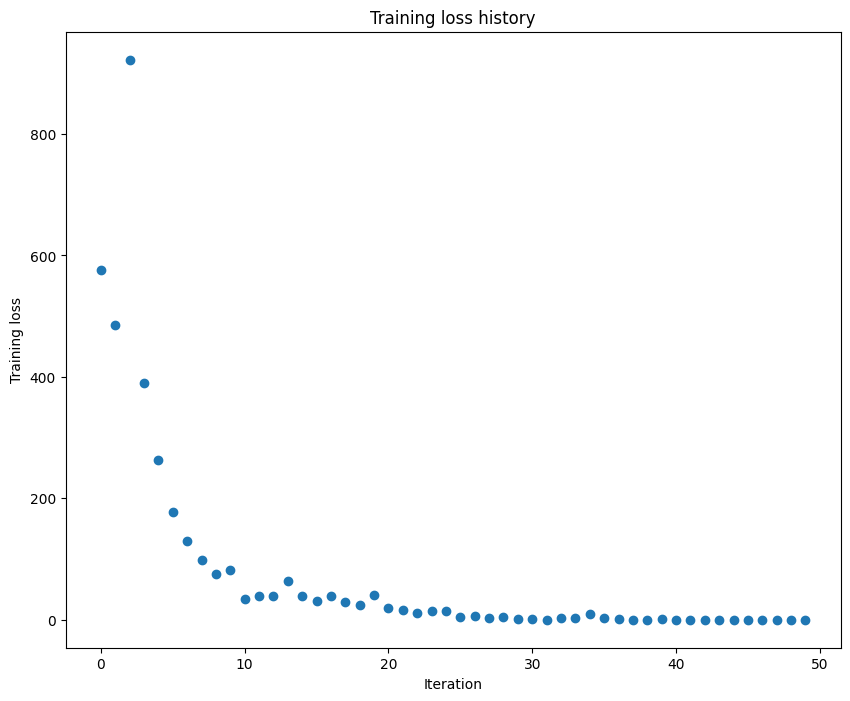

In [53]:
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}


#############################################################
# tweaking just the learning rate and initialization scale.
#############################################################

input_dim = 3*32*32

weight_scale = 0.1
learning_rate = 1e-4

#############################################################
#                 end of your tweaking                      #
#############################################################

model = FullyConnectedNet(
    [100, 100],
    weight_scale=weight_scale,
    dtype=np.float64

)
solver = Solver(
    model, small_data,
    print_every=10, num_epochs=25, batch_size=25,
    update_rule='sgd',
    optim_config={'learning_rate': learning_rate,}
)
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

<font size='4' color='red'>**Task 2.5: Overfitting a small dataset with a five-layer network (5 points).**
    
<font size='4'>Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 294.202620
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.114000
(Epoch 1 / 20) train acc: 0.120000; val_acc: 0.087600
(Epoch 2 / 20) train acc: 0.200000; val_acc: 0.110200
(Epoch 3 / 20) train acc: 0.300000; val_acc: 0.112400
(Epoch 4 / 20) train acc: 0.220000; val_acc: 0.102600
(Epoch 5 / 20) train acc: 0.340000; val_acc: 0.105700
(Iteration 11 / 40) loss: 42.804102
(Epoch 6 / 20) train acc: 0.400000; val_acc: 0.117400
(Epoch 7 / 20) train acc: 0.400000; val_acc: 0.116200
(Epoch 8 / 20) train acc: 0.520000; val_acc: 0.113300
(Epoch 9 / 20) train acc: 0.600000; val_acc: 0.112800
(Epoch 10 / 20) train acc: 0.580000; val_acc: 0.122400
(Iteration 21 / 40) loss: 4.348154
(Epoch 11 / 20) train acc: 0.640000; val_acc: 0.123300
(Epoch 12 / 20) train acc: 0.760000; val_acc: 0.127300
(Epoch 13 / 20) train acc: 0.720000; val_acc: 0.131800
(Epoch 14 / 20) train acc: 0.820000; val_acc: 0.130600
(Epoch 15 / 20) train acc: 0.880000; val_acc: 0.130700
(Iteration 31 / 40) los

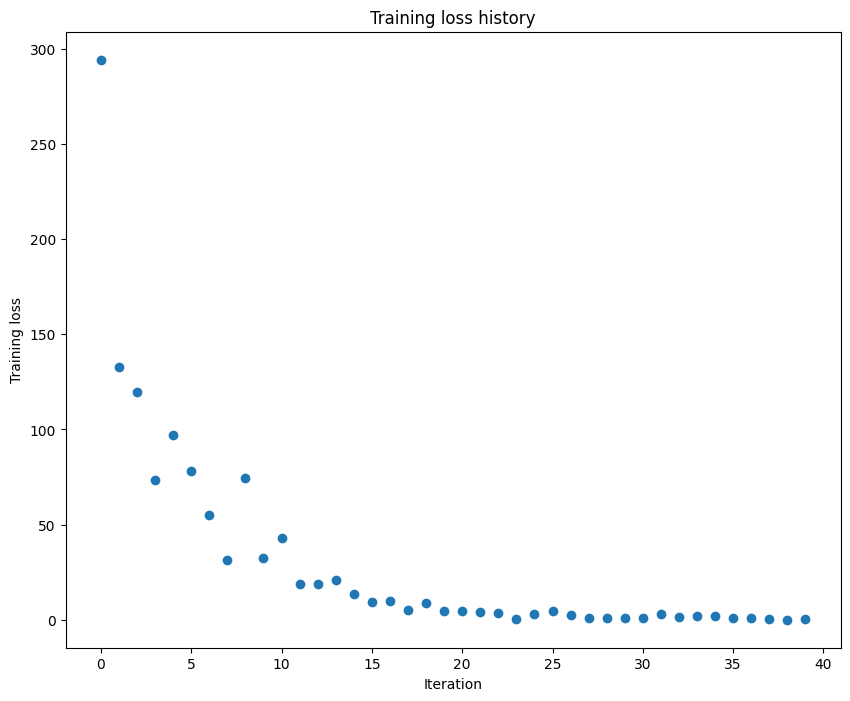

In [84]:
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}


#############################################################
# tweaking just the learning rate and initialization scale.
#############################################################

import numpy as np


weight_scale = 0.095

learning_rate = 1e-4

#############################################################
#                 end of your tweaking                      #
#############################################################

model = FullyConnectedNet(
    [100, 100, 100, 100],
    weight_scale=weight_scale,
    dtype=np.float64
)

solver = Solver(
    model, small_data,
    print_every=10, num_epochs=20, batch_size=25,
    update_rule='sgd',
    optim_config={'learning_rate': learning_rate,}
)
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

<font size='4' color='red'>**Inline Question 2.6 (2 points):**
    
<font size='4' color='red'>**Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?**

<font size='4'>**Answer:**
    
Training the five-layer network was noticeably more challenging than the three-layer network, particularly in how it responded to weight initialization. The five-layer model was much more sensitive to the choice of weight scale. When initialized with very small values, gradients diminished too quickly as they moved through the layers, making learning slow and ineffective. On the other hand, when the weights were too large, activations and gradients exploded, leading to unstable training.

Deeper networks like the five-layer model faced more severe issues with vanishing and exploding gradients compared to the three-layer network. With more layers, small initial weights caused activations to shrink exponentially, preventing the model from making meaningful updates. Larger weights resulted in excessively high activations, making the optimization process erratic. The three-layer network, in contrast, was easier to tune and achieved 100% training accuracy much faster with reasonable adjustments to weight scale and learning rate. I still am struggling to achieve 100% accuracy for the five-layer network!

Beyond initialization, the five-layer network also required more precise learning rate tuning. A learning rate that worked well for the three-layer network either slowed down training or led to divergence in the deeper model. The loss landscape of the five-layer network was also more complex, making optimization more difficult. These challenges show that as networks get deeper, proper initialization and learning rate selection become even more crucial for stable and efficient training.


<font size='4' color='red'>**Task 2.7: SGD+Momentum (5 points)**
    
<font size='4'>Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent.

<font size='4'>Open the file `utils/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule below and run the following to check your implementation. You should see errors less than 1e-8.

In [148]:
def sgd_momentum(w, dw, config=None):
    """
    Performs stochastic gradient descent with momentum.

    config format:
    - learning_rate: Scalar learning rate.
    - momentum: Scalar between 0 and 1 giving the momentum value.
      Setting momentum = 0 reduces to sgd.
    - velocity: A numpy array of the same shape as w and dw used to store a
      moving average of the gradients.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)
    config.setdefault('momentum', 0.9)
    v = config.get('velocity', np.zeros_like(w))

    next_w = None
    ###########################################################################
    # TODO: Implement the momentum update formula. Store the updated value in #
    # the next_w variable. You should also use and update the velocity v.     #
    ###########################################################################

    v = config['momentum'] * v - config['learning_rate'] * dw
    # Update the weights
    next_w = w + v


    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    config['velocity'] = v

    return next_w, config

In [149]:
# Let's check your implementation
N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


running with  sgd
(Iteration 1 / 200) loss: 4.266991
(Epoch 0 / 5) train acc: 0.135000; val_acc: 0.120700
(Iteration 11 / 200) loss: 2.250813
(Iteration 21 / 200) loss: 2.208552
(Iteration 31 / 200) loss: 2.371821
(Epoch 1 / 5) train acc: 0.243000; val_acc: 0.216500
(Iteration 41 / 200) loss: 2.015659
(Iteration 51 / 200) loss: 2.062946
(Iteration 61 / 200) loss: 1.989384
(Iteration 71 / 200) loss: 2.085965
(Epoch 2 / 5) train acc: 0.270000; val_acc: 0.250500
(Iteration 81 / 200) loss: 1.975489
(Iteration 91 / 200) loss: 1.976850
(Iteration 101 / 200) loss: 1.924170
(Iteration 111 / 200) loss: 1.923115
(Epoch 3 / 5) train acc: 0.283000; val_acc: 0.268500
(Iteration 121 / 200) loss: 1.889382
(Iteration 131 / 200) loss: 1.944437
(Iteration 141 / 200) loss: 2.149855
(Iteration 151 / 200) loss: 1.942332
(Epoch 4 / 5) train acc: 0.285000; val_acc: 0.239100
(Iteration 161 / 200) loss: 1.970963
(Iteration 171 / 200) loss: 1.941772
(Iteration 181 / 200) loss: 2.047578
(Iteration 191 / 200) los

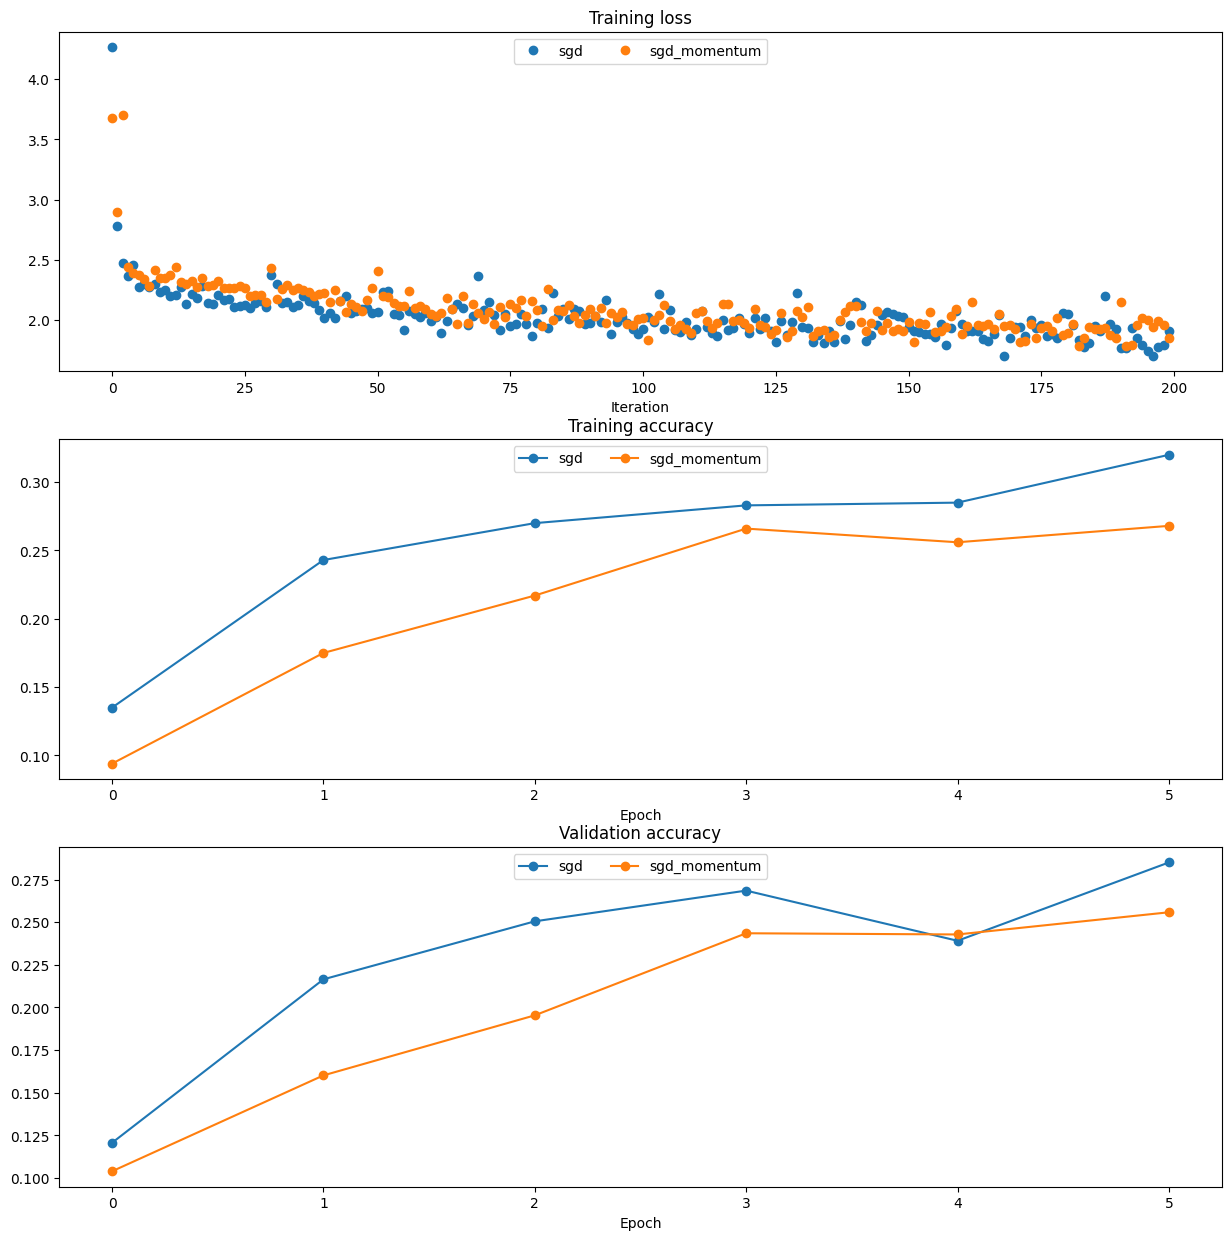

In [150]:
# Run the following to train a six-layer network with both SGD and SGD+momentum.
# You should see the SGD+momentum update rule converge faster.
from utils.solver import Solver

num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

    solver = Solver(
        model, small_data,
        num_epochs=5, batch_size=100,
        update_rule=update_rule if update_rule == 'sgd' else sgd_momentum,
        optim_config={'learning_rate': 1e-2,},
        verbose=True
    )

    solvers[update_rule] = solver
    solver.train()
    print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)

for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

<font size='4' color='red'>**Task 2.8: Train a good model! (7 points)**
    
<font size='4'>Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. <font color='red'>We require you to get at least 50% accuracy on the validation set using a fully-connected net within 50 epochs.

<font size='4'>If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so.

In [86]:
best_model = None
model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. Your best   #
# model will be stored in the best_model variable.                             #
################################################################################
import numpy as np


best_weight_scale = np.sqrt(2.0 / (3 * 32 * 32))
best_learning_rate = 1e-3
best_batch_size = 128
best_reg = 0.001



model = FullyConnectedNet(
    hidden_dims=[512, 256, 128, 64],
    input_dim=3 * 32 * 32,
    num_classes=10,
    weight_scale=best_weight_scale,
    reg=best_reg,
    dtype=np.float32
)



solver = Solver(
    model, data,
    print_every=100, num_epochs=50, batch_size=best_batch_size,
    update_rule='sgd',
    optim_config={'learning_rate': best_learning_rate, 'momentum': 0.9}
)


solver.train()

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

best_model = model
best_model.params.update(solver.best_params)

(Iteration 1 / 19500) loss: 2.862972
(Epoch 0 / 50) train acc: 0.092000; val_acc: 0.097800
(Iteration 101 / 19500) loss: 2.744202
(Iteration 201 / 19500) loss: 2.601907
(Iteration 301 / 19500) loss: 2.554009
(Epoch 1 / 50) train acc: 0.280000; val_acc: 0.300900
(Iteration 401 / 19500) loss: 2.663005
(Iteration 501 / 19500) loss: 2.532473
(Iteration 601 / 19500) loss: 2.412652
(Iteration 701 / 19500) loss: 2.482672
(Epoch 2 / 50) train acc: 0.355000; val_acc: 0.353000
(Iteration 801 / 19500) loss: 2.438619
(Iteration 901 / 19500) loss: 2.447593
(Iteration 1001 / 19500) loss: 2.360073
(Iteration 1101 / 19500) loss: 2.379358
(Epoch 3 / 50) train acc: 0.377000; val_acc: 0.370800
(Iteration 1201 / 19500) loss: 2.318531
(Iteration 1301 / 19500) loss: 2.360705
(Iteration 1401 / 19500) loss: 2.238988
(Iteration 1501 / 19500) loss: 2.232281
(Epoch 4 / 50) train acc: 0.386000; val_acc: 0.388400
(Iteration 1601 / 19500) loss: 2.369254
(Iteration 1701 / 19500) loss: 2.217370
(Iteration 1801 / 1950

In [89]:
# Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.
from sklearn.model_selection import train_test_split


X_val, X_test, y_val, y_test = train_test_split(
    data['X_val'], data['y_val'], test_size=0.2, random_state=42
)

data = {
    'X_train': data['X_train'],
    'y_train': data['y_train'],
    'X_val': X_val,
    'y_val': y_val,
    'X_test': X_test,
    'y_test': y_test
}

print(data.keys())
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

dict_keys(['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test'])
Validation set accuracy:  0.504625
Test set accuracy:  0.5005
